In [1]:
import os
import neptune
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from scipy.stats import ttest_ind as ttest
from scipy.stats import kendalltau,spearmanr
import scipy
import xarray as xr
from scipy.spatial.distance import pdist,squareform,cdist
from sklearn.preprocessing import StandardScaler

# from tensorflow.python import keras as keras
from keras.models import Model

from src.results.experiments import _DateExperimentLoader
from src.results.utils import raw_to_xr, dprime
from src.results.neptune import get_model_files, load_models, load_assemblies, load_params, load_properties,prep_assemblies,NeptuneExperimentRun,generate_convnet_encoders
from src.results.dicarlo import get_dicarlo_su
from src.data_loader import Shifted_Data_Loader
from src.data_generator import ShiftedDataBatcher
from src.rcca import CCA

import brainscore
from brainscore.assemblies import walk_coords,split_assembly
from brainscore.assemblies import split_assembly
# from brainscore.metrics import Score

from brainio_base.assemblies import DataAssembly

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("talk")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Georgia","Times New Roman", "Palatino", "serif"]
    })

Using TensorFlow backend.


In [2]:
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI3ZWExMTlmYS02ZTE2LTQ4ZTktOGMxMi0wMDJiZTljOWYyNDUifQ=="
neptune.init('elijahc/DuplexAE')
neptune.set_project('elijahc/DuplexAE')
proj_root = '/home/elijahc/projects/vae'

In [3]:
def load_config(exps):
    props = load_properties(exps)
    params = load_params(exps)
    ids = [e.id for e in exps]
    for eid,pr,pa in zip(ids,props,params):
        out = {'id':eid}
        out.update(pr)
        out.update(pa)
        out['exp_dir']=os.path.join(proj_root,pr['dir'])
        yield out

In [4]:
conv_eids = [
    'DPX-29',
    'DPX-30',
]
dense_eids = [
    'DPX-10',
    'DPX-16',
#     'DPX-27',
]
# eids = conv_eids+dense_eids
conv_exps = neptune.project.get_experiments(id=conv_eids)
dense_exps = neptune.project.get_experiments(id=dense_eids)
exps = np.array(conv_exps+dense_exps)
s_df = pd.DataFrame(list(load_config(exps)))
s_df.head()

,assembly_fn,augmentation,batch_sz,bg,bg_contrast,dataset,dir,encoder_arch,exp_dir,generator_arch,id,im_translation,n_epochs,recon_weight,su_selectivity_fn,xent_weight,y_dim,z_dim
0,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-11-04/DPX-29,convnet,/home/elijahc/projects/vae/models/2019-11-04/D...,resnet,DPX-29,0.75,54000.0,0.0,NaN,15.0,35,35
1,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-11-04/DPX-30,convnet,/home/elijahc/projects/vae/models/2019-11-04/D...,resnet,DPX-30,0.75,54000.0,1.0,NaN,15.0,35,35
2,dataset.nc,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-10,dense,/home/elijahc/projects/vae/models/2019-09-25/D...,resnet,DPX-10,0.75,54000.0,1.0,selectivity.pqt,15.0,35,35
3,NaN,dynamic,512.0,natural,0.3,fashion_mnist,models/2019-09-25/DPX-16,dense,/home/elijahc/projects/vae/models/2019-09-25/D...,resnet,DPX-16,0.75,54000.0,0.0,NaN,15.0,35,35


In [5]:
run = NeptuneExperimentRun(proj_root,conv_exps[0])

In [6]:
def load_rdm(file_paths):
    for fp in file_paths:
        x = xr.open_dataarray(fp)
#         print(x)
        p_idxs = ['image_id','rxy','category_name','object_name']
        yield x.set_index(image_1=[p+'_1' for p in p_idxs],image_2=[p+'_2' for p in p_idxs])

In [7]:
def process_dicarlo(assembly,avg_repetition=True, variation=[0, 3, 6], tasks=['ty','tz','rxy']):
    stimulus_set = assembly.attrs['stimulus_set']
    stimulus_set['dy_deg'] = stimulus_set.tz*stimulus_set.degrees
    stimulus_set['dx_deg'] = stimulus_set.ty*stimulus_set.degrees
    stimulus_set['dy_px'] = stimulus_set.dy_deg*32
    stimulus_set['dx_px'] = stimulus_set.dx_deg*32
    
    assembly.attrs['stimulus_set'] = stimulus_set
    
    groups = ['category_name', 'object_name', 'image_id']+tasks
    if not avg_repetition:
        groups.append('repetition')
        
    data = assembly.multi_groupby(groups)     # (2)
    data = data.mean(dim='presentation')
    data = data.squeeze('time_bin')    #   (3)
#     data.attrs['stimulus_set'] = stimulus_set.query('variation == {}'.format(variation))
    data = data.T
    data = data[stimulus_set.variation.isin(variation),:]
    
    return data

In [8]:
from tqdm import trange
def gen_conv_assemblies(encodings,depths,stim_set,n=5):
    enc = {k:encodings[k] for k in ['pixel','y_enc','z_enc']}
    for i in np.arange(n):
        enc.update({k:encodings[k][:,:,i] for k in ['conv_4','conv_3','conv_2','conv_1']})
        yield raw_to_xr(enc,depths,stim_set)

In [9]:

# stimulus_set = neural_data.attrs['stimulus_set']
# stimulus_set = pd.read_csv('../data/dicarlo_images/stimulus_set.csv')
# stimulus_set['dy_deg'] = stimulus_set.tz*stimulus_set.degrees
# stimulus_set['dx_deg'] = stimulus_set.ty*stimulus_set.degrees
# stimulus_set['dy'] = stimulus_set.dy_deg*32
# stimulus_set['dx'] = stimulus_set.dx_deg*32
# stimulus_set.to_csv('../data/dicarlo_images/stimulus_set.csv',index=False)
# stimulus_set



In [10]:
# stimulus_set.to_csv('../data/dicarlo_images/stimulus_set.csv',index=False)

In [11]:
# sm_imgs = np.load('../data/dicarlo_images/sm_imgs_56x56.npy')
# sm_imgs = np.expand_dims(sm_imgs,-1)
# slug = [(dx,dy,lab,float(rxy)) for dx,dy,rxy,lab in zip(stimulus_set.dx_px.values,stimulus_set.dy_px.values,stimulus_set.rxy.values,stimulus_set.category_name.values)]

In [12]:
def is_iterable(obj):
    try:
        some_object_iterator = iter(some_object)
        return True
    except TypeError as te:
        print(some_object, 'is not iterable')
        return False

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr,pearson3

def dicarlo_rdm(data, stimulus_set, region=['V4','IT'],sortby='category_name', variation=[0,3,6], metric='correlation',n_sample=150):
#     if region is not None:
#         data = data.sel(region=region)
    
    var_lookup = stimulus_set[stimulus_set.variation.isin(variation)].image_id.values
    data = data.where(data.image_id.isin(var_lookup),drop=True)
    print(data.shape)
    out_dict = {'region':[],'variation':[],'rdm':[]}
    xrs = []
    for reg in region:
#         for v in variation:
        sub_dat = data.sel(region=reg)
        if sortby is not None:
            sub_dat = sub_dat.sortby(sortby)
        
        if sub_dat.shape[1] > n_sample:
            s_idxs = np.random.choice(np.arange(sub_dat.shape[1]),size=n_sample,replace=False)
        else:
            n_sample = int(0.8 * sub_dat.shape[1])
            s_idxs = np.random.choice(np.arange(sub_dat.shape[1]),size=n_sample,replace=False)
        
        if metric is 'cosine_similarity':
            rdm = 1-cosine_similarity(sub_dat[:,s_idxs])
            
        else:
#             print(sub_dat.values.shape)
            num_images = sub_dat.values.shape[0]
#             print(sub_dat[:,s_idxs].values.shape)
            rdm = squareform(pdist(sub_dat[:,s_idxs].values,metric=metric))
#             rdm = np.empty(shape=(num_images,num_images))
        
#             for i in trange(num_images):
#                 for j in np.arange(num_images):
#                     r,p = pearsonr(sub_dat.values[i],sub_dat.values[j])
                    
        out_dict['region'].append(reg)
        out_dict['rdm'].append(rdm)
#             out_dict['image_id'].append(sub_dat.image_id.values)
        p = sub_dat.presentation.to_index()
        xrs.append(xr.DataArray(rdm,
                               coords={
                                   'image_1':p.set_names(tuple([n+'_1' for n in p.names])),
                                   'image_2':p.set_names(tuple([n+'_2' for n in p.names])),
#                                        'variation':v,
                                   'region':reg,
                               },
                               dims=('image_1','image_2'),
                               ))
    
    return xr.concat(xrs,'all')

In [14]:
def plot_rdm(data,sortby=None,figsize=(4,4), ax=None):
    # Expects da object of shape(N,N)
    if sortby is not None:
        data = data.sortby([sortby+'_1',sortby+'_2'])
    
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=figsize)
        
    labels = data[sortby+'_1'].values
    sns.heatmap(data,ax=ax)
    yticks = [int(l._text) for l in list(ax.get_yticklabels())]
    xticks = [int(l._text) for l in list(ax.get_xticklabels())]
    ax.set_yticklabels(labels[yticks])
    ax.set_xticklabels(labels[xticks])
    ax.set_title(np.unique(data.region.values)[0])
    
    if ax is None:
        return fig,ax
    else:
        return ax

In [15]:
neural_data = brainscore.get_assembly(name="dicarlo.Majaj2015")
neural_data.load()
stimulus_set = neural_data.attrs['stimulus_set']
# # stimulus_set.to_csv('../data/dicarlo_images/stimulus_set.csv',index=False)
neural_data = process_dicarlo(neural_data)

/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:247: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.reset_index(self.multi_group_name, drop=True, inplace=True)
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:248: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.set_index(append=True, inplace=True, **{self.multi_group_name: self.group_coord_names})


In [16]:
sm_imgs = np.load('../data/dicarlo_images/sm_imgs_56x56.npy')

ids0 = stimulus_set[stimulus_set.variation.values==0].image_id.values
ids3 = stimulus_set[stimulus_set.variation.values==3].image_id.values

sm_ims = list(zip(ids3,sm_imgs[stimulus_set.variation.values==3]))

In [17]:
# it_resp = neural_data.sel(region='IT')
# it_resp = it_resp[it_resp.image_id.isin(ids3)]
# # itp_df = it_resp.presentation.to_dataframe().reset_index()
# # idxs3 = itp_df.image_id.isin(ids3)
# # sm3 = sm_imgs[]

In [18]:
# scaler = StandardScaler()

# scaled_sm_imgs = scaler.fit_transform(sm_imgs.reshape(5760,56*56)).reshape(5760,56,56)
Xm,Xs = (sm_imgs.mean(),sm_imgs.std())
scaled_sm_imgs = np.clip((sm_imgs-Xm)/Xs,-1,1)

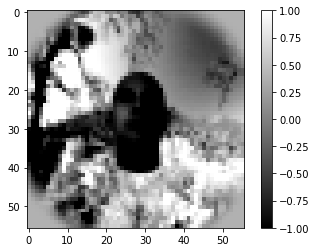

In [22]:
plt.imshow(scaled_sm_imgs[2],cmap='gray')
plt.colorbar()

(array([1001313., 1786480., 2573987., 2969970., 3213603., 3133374.,
        1502566.,  994418.,  633668.,  253981.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

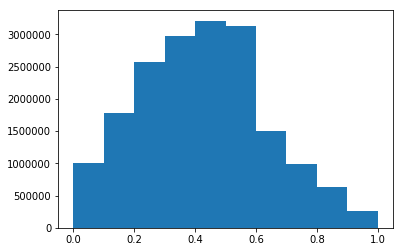

In [23]:
plt.hist(sm_imgs.flatten())

In [24]:
DL = ShiftedDataBatcher('fashion_mnist',rotation=None,flatten=False, bg='natural')

In [25]:
batch = next(DL.gen_test_batches(num_batches=10,batch_size=512,bg='natural'))

In [26]:
batch[0].shape

(512, 56, 56, 1)

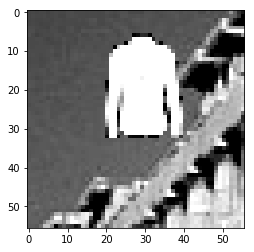

In [27]:
plt.imshow(batch[0][25].reshape(56,56),cmap='gray')

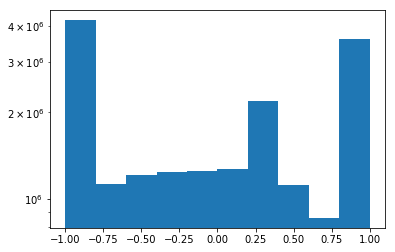

In [28]:
plt.hist(scaled_sm_imgs.flatten())
plt.yscale('log')

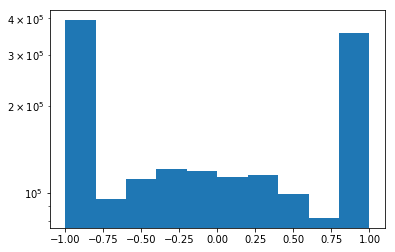

In [29]:
plt.hist(batch[0].flatten())
plt.yscale('log')

In [31]:
import src.rcca as rcca
from sklearn.cross_decomposition import CCA

In [32]:
from sklearn.model_selection import train_test_split
import src.rcca as rcca
from sklearn.cross_decomposition import CCA
def dicarlo_cca(data,stimulus_set,region,variation=[3],cv=10):
    var_lookup = stimulus_set[stimulus_set.variation.isin(variation)].image_id.values
    data = data.where(data.image_id.isin(var_lookup),drop=True)
    nd = neural_data.where(neural_data.image_id.isin(var_lookup),drop=True)
    
    data = data.sortby('image_id')
    nd = nd.sortby('image_id')
    
#     print(data.image_id.values)
#     print(nd.image_id.values)
    
    print('same order? \t',list(data.sortby('image_id').image_id.values) == list(nd.sortby('image_id').image_id.values))
    
    print('model.shape\t',data.shape)
    print('dicarlo.shape\t',nd.shape)
    out_dict = {'region':[],
#                 'variation':[],
#                 'rdm':[],
                'layer':[],
                'pearsonr':[],
                'p-value':[],
                'iter':[],
               }
    xrs = []
    ab_vectors = []
    ccas = []
        
    cv_tr = []
    cv_te = []
    
    num_images = data.shape[0]
    print(num_images)
    
    for rand_delta in np.arange(cv):
        tr_idx, te_idx, _,_ = train_test_split(np.arange(num_images),np.arange(num_images),train_size=0.75,random_state=np.random.randint(0,50)+rand_delta)
        cv_tr.append(tr_idx)
        cv_te.append(te_idx)
        
    for reg in region:
        sub_dat = data.sel(region=reg)
#         print(sub_dat)
        
        for brain_region in ['V4','IT']:
            
            pairing = '{} x {}'.format(reg,brain_region)
            for n, tr,te in tqdm(zip(np.arange(cv),cv_tr,cv_te),total=cv,desc=pairing):
                cca = CCA(n_components=1)
                cca.fit(sub_dat.values[tr],nd.sel(region=brain_region).values[tr])
            
                ab_vec = cca.transform(sub_dat.values[te],nd.sel(region=brain_region).values[te])
        
                r,pv = pearsonr(ab_vec[0],ab_vec[1])

                out_dict['region'].append(brain_region)
                out_dict['layer'].append(reg)
                out_dict['pearsonr'].append(r[0])
                out_dict['p-value'].append(pv[0])
                out_dict['iter'].append(n)
            
#             print(out_dict)
        
#         ccas.append(cca)
        
#         cca_score = r
        
#         cca_score = cca.score(sub_dat.values,nd.sel(region='IT').values)
        
#         cca = CCA(kernelcca = False, reg = 0.001, numCC = 2)
    
#         X_tr, X_te, y_tr, y_te = train_test_split(np.arange(2560),np.arange(2560))
        
#         data_vecs = [sub_dat.values,sub_dat.values,nd.sel(region='IT').values,nd.sel(region='IT').values]
        
#         idxs = [X_tr, X_te, y_tr, y_te]
        
#         X_tr,X_te, y_tr, y_te = tuple([d[idx] for d,idx in zip(data_vecs,idxs)])
        
# #         ,nd.sel(region='IT').values
        
#         print(X_tr.shape,y_tr.shape)
#         print(X_te.shape,y_te.shape)
        
#         cca.train([X_tr,y_tr])
        
#         cca_score = cca.validate([X_te,y_te])
#         print([t.shape for t in cca_score])

#         xrs.append(cca_score)
        
    return out_dict
        

In [33]:
from src.results.utils import get_layer_encoders


In [ ]:
def mod_cca(imgs,stim):
    iid = stim.image_id.values
    on = stim.object_name.values
    conv_rdm=[]
    imgs = np.expand_dims(imgs,-1)
    slug = [(dx,dy,lab,float(rxy)) for dx,dy,rxy,lab in zip(stim.dx_px.values,stim.dy_px.values,stim.rxy.values,stim.category_name.values)]
    models = ['No-recon', 'w/ Recon']
    i=0
    for encodings, depths, stim_set in prep_assemblies(proj_root,conv_exps,test_data=imgs,slug=slug,image_id=iid,object_name=on):

        stim_set['variation']=stim.variation
        xrs  = gen_conv_assemblies(encodings,depths,stim_set,n=3)
        print('generating cca')
        res_dict = dicarlo_cca(next(xrs),stim_set,region=['conv_1','conv_2','conv_3','conv_4','y_enc','z_enc'],variation=[0,3,6],cv=35)
        res_df = pd.DataFrame.from_records(res_dict)
        res_df['model']= models[i]
#         drdm = dicarlo_rdm(next(xrs),stim_set,region=['conv_1','conv_2','conv_3','conv_4','y_enc','z_enc',],variation=[3],metric='correlation')
        conv_rdm.append(res_df)
        i+=1
    return pd.concat(conv_rdm)

In [ ]:
conv_cca_036 = mod_cca(scaled_sm_imgs, stim)

In [ ]:
(3*192*4)+(56*56)+70

In [ ]:
    sns.lineplot(x='layer',y='pearsonr',style='model',hue='region',
#                  data=conv_cca.query('{} == "{}"'.format(split_on,col)),
                 data=conv_cca_036,)
    
    plt.xticks(rotation=45)

In [ ]:
conv_cca_36 = mod_cca(scaled_sm_imgs, stim)

In [ ]:
    sns.lineplot(x='layer',y='pearsonr',style='model',hue='region',
#                  data=conv_cca.query('{} == "{}"'.format(split_on,col)),
                 data=conv_cca_36,)
    
    plt.xticks(rotation=45)

In [ ]:
# x_tr,x_te, y_tr,y_te = train_test_split(neural_data.sel(region='IT'),neural_data.sel(region='V4'))

In [ ]:
stim = stimulus_set.copy()

In [ ]:
# conv_cca = list(mod_cca(scaled_sm_imgs,stim))

In [ ]:
conv_cca = mod_cca(scaled_sm_imgs,stim)

In [ ]:
sns.set_context('talk')

In [ ]:
    sns.lineplot(x='layer',y='pearsonr',style='model',hue='region',
#                  data=conv_cca.query('{} == "{}"'.format(split_on,col)),
                 data=conv_cca,)
    
    plt.xticks(rotation=45)

In [ ]:
g = sns.FacetGrid(col='region',row='model',data=conv_cca,height=5)
g.map(sns.stripplot,'layer','pearsonr')
g.fig.autofmt_xdate(rotation=45)

In [ ]:



def mod_rdm(imgs,stim):
    iid = stim.image_id.values
    on = stim.object_name.values
    conv_rdm=[]
    imgs = np.expand_dims(imgs,-1)
    slug = [(dx,dy,lab,float(rxy)) for dx,dy,rxy,lab in zip(stim.dx_px.values,stim.dy_px.values,stim.rxy.values,stim.category_name.values)]
    for encodings, depths, stim_set in prep_assemblies(proj_root,conv_exps,test_data=imgs,slug=slug,image_id=iid,object_name=on,n_units=300):
        stim_set['variation']=stim.variation
        xrs  = gen_conv_assemblies(encodings,depths,stim_set,n=3)
        drdm = dicarlo_rdm(next(xrs),stim_set,region=['conv_1','conv_2','conv_3','conv_4','y_enc','z_enc',],variation=[3],metric='correlation')
        conv_rdm.append(drdm)
    return conv_rdm

In [ ]:
conv_rdm = list(mod_rdm(scaled_sm_imgs,stim))


In [ ]:
cdf = pd.DataFrame(list(load_config(conv_exps)))
for e,crdm in zip(cdf.exp_dir.values,conv_rdm):
    da = crdm.reset_index(['image_1','image_2'])
    with open(os.path.join(e,'dicarlo_rdm_pearson.nc'), 'wb') as fp:
        da.to_netcdf(fp)

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
for i,ax in enumerate(axs):
    plot_rdm(conv_rdm[i][4], figsize=(5,5), sortby='category_name', ax=ax);

In [ ]:
# monkey_rdm = dicarlo_rdm(neural_data, stimulus_set,variation=[3],metric='correlation',)
# da = monkey_rdm.reset_index(['image_1','image_2'],)
# with open(os.path.join('../data/dicarlo_images','monkey_rdm_pearson.nc'), 'wb') as fp:
#     da.to_netcdf(fp)
# # conv_assemblies = load_assemblies(proj_root,conv_exps)


In [ ]:
# models = load_models(proj_root,conv_exps[0:1],load_weights=False)
# mod = next(models)

In [ ]:
# mod.layers[1].summary()

In [ ]:
# fig,axs = plot_rdm(monkey_rdm[1], figsize=(5,5), sortby='category_name');
# fig.tight_layout()
# # plt.tight_layout()

In [ ]:
neural_data.sortby('category_name').image_id.values

In [ ]:
fig.savefig('../figures/pub/IT_rdm.png', dpi=150)

In [ ]:

monkey_fp = '../data/dicarlo_images/monkey_rdm_pearson.nc'


# monkey_rdm = next(load_rdm([monkey_fp]))
# subset = monkey_rdm.image_id_1.isin(ids3)
it_rdm = monkey_rdm[1]
v4_rdm = monkey_rdm[0]

In [ ]:

# cdf = pd.DataFrame(list(load_config(conv_exps)))
# mod_rdm_fps = pd.DataFrame(list(load_config(conv_exps))).exp_dir.values
# mod_rdm_fps = [fp+'/dicarlo_rdm_pearson.nc' for fp in mod_rdm_fps]
# xrs = list(load_rdm(mod_rdm_fps))

In [ ]:
# sortby='image_id'
# sorter = [sortby+'_1',sortby+'_2']
# xrs[0][0].sortby(sorter).image_id_1.values==monkey_rdm[0].sortby(sorter).image_id_1.values

In [ ]:
def calc_model_kt(m_rdm, exps, sortby='image_id'):
    
    cdf = pd.DataFrame(list(load_config(exps)))
    mod_rdm_fps = pd.DataFrame(list(load_config(exps))).exp_dir.values
    mod_rdm_fps = [fp+'/dicarlo_rdm_pearson.nc' for fp in mod_rdm_fps]
    
#     print(mod_rdm_fps)
    xrs = list(load_rdm(mod_rdm_fps))
#     print(xrs)
    
    kt = []
    sorter = [sortby+'_1',sortby+'_2']
    
    for i in np.arange(len(mod_rdm_fps)):
        for j in trange(5):
            mod_rdm = xrs[i][j+1]
            for k,reg in enumerate(['V4','IT']):
#                 print(k,reg)
                ru = m_rdm[k].sortby(sorter)
                rv = mod_rdm.sortby(sorter)
#                 print(ru)
#                 print()
#                 print(rv)
                ktp =  kendalltau(ru,rv)
                kt.append({'kendalltau':ktp[0],'p-value':ktp[1],'layer':np.unique(rv.region.values)[0],'encoder_arch':cdf.encoder_arch.values[i],'recon_weight':cdf.recon_weight.values[i],'region':reg})
                

    kt_df = pd.DataFrame.from_records(kt)
    return kt_df
        
kt_df = calc_model_kt(monkey_rdm,conv_exps,sortby='category_name')
kt_df.head()

In [ ]:
sns.set_context('paper')

fig, axs = plt.subplots(2,2,figsize=(5,5), sharey=True,sharex=True)
for i,reg in enumerate(['V4','IT']):
    for j,recon in enumerate([0.0,1.0]):
        ax=axs[i,j]
        sns.barplot(x='layer',y='kendalltau',
                    data=kt_df.query('region == "{}" and recon_weight == {}'.format(reg,recon)),
                    ax=ax, palette='magma')
        ax.set_ylabel(r'Kendall $\tau$')
        ax.set_title('{} | recon={}'.format(reg,recon))

    
#     ax.set_title(reg)

for ax,recon in zip(axs[:,1].ravel(),[0,1]):
#     ax.set_ylabel('recon = {}'.format(recon))
    pass
    
for ax in axs[1]:
    xlab = ax.get_xticklabels()
    ax.set_xticklabels(xlab,rotation=90)

plt.tight_layout()

In [ ]:
fig.savefig('../figures/pub/kendalltau.pdf', dpi=300)